# SEGMENTATION DE LESIONS CUTANEES

Selon l'OMS, il y a entre 2 et 3 millions de mélanomes non cancéreux, pour environ 132000 cancéreux. Cela se traite facielement à condition d'être dépisté tôt. En revanche, le diagnostique peut s'avérer compliqué de par la ressemblance des mélanomes avec les nævus. Ces mélanomes peuvent être détectés avec des moyens numériques, qui nécessitent cependant une très bonne segmentation des lésions. 


Sauf mention contraire, toutes les fonctions ont été codées par nous-mêmes.

In [ ]:
from scipy.ndimage import convolve
import numpy as np
import skimage
from skimage import io
from skimage import morphology 
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import interpolate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from google.colab import drive
import os

# Open data

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


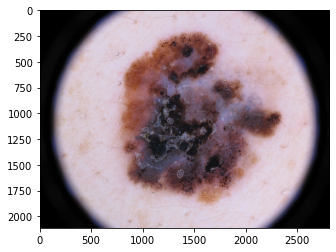

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/dataset-skinlesions/melanoma/ISIC_0000140.jpg'
img = io.imread(filepath)
plt.imshow(img)
plt.show()

# Pre Processing

Le pré-processing, donc avant la segmentation, permet de préparer l'image à être segmentée. 

L'image nécessite un masque de recadrage, d'enlever les cheveux lorsqu'il y en a, et de réduire les défauts d'ombres lorsqu'il y en a.

## Recadrage

On cherche à déterminer la zone de travail de la segmentation. En effet, certaines images comportent des bordures sombres (dues au microsope) inexpoitables. 


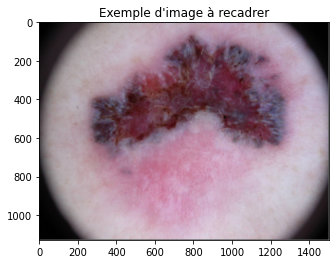

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/dataset-skinlesions/melanoma/ISIC_0000030.jpg'
img = io.imread(filepath)
plt.imshow(img)
plt.title("Exemple d'image à recadrer")
plt.show()

In [ ]:
def ombres(img):

    """
    :param img : l'image RGB  
    :return: Un masque binaire obtenu via un seuillage grossier (pour obtenir les zones zombres)
    """
    
    img_gray = skimage.color.rgb2gray(img)
    thresh = threshold_otsu(img_gray)
    binary_img = img_gray < thresh
    radius = 10
    binary_img = morphology.binary_erosion(image=binary_img, selem=morphology.disk(radius))
    binary_img = morphology.binary_dilation(image=binary_img, selem=morphology.rectangle(50,5)) 
    binary_img = morphology.binary_dilation(image=binary_img, selem=morphology.rectangle(5,50))
    return binary_img    #Boolean

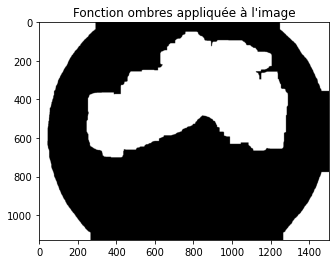

In [ ]:
plt.imshow(ombres(img), cmap = 'gray')
plt.title("Fonction ombres appliquée à l'image")
plt.show()

Pour obtenir le masque de recadrage, on cherche sur les diagonales le plus grand segment correspondant à des bordures, de manières à ensuite pouvoir sélectionner un disque contenant la lésion et des zones de peau sans bordures.

Il faut faire attention, car toutes les images contiennent une sorte de bordures bizarre de quelques pixels, invisible à l'oeil nu.

In [ ]:
def get_mask(img):

  """
  :param img : l'image RGB  
  :return: Un masque (disque) correspondant à la zone sans bordure (Matrice de 1 si pas de bordure)
  """
    
  nlin, ncol, _ = np.shape(img)

  #On forme un masque pour le recadrage
  binary_img = ombres(img)

  count = 0
  i = 0
  while(binary_img[i][i]):
    count += 1
    i += 1 
  r1 = count

  count = 0
  i = 1
  while(binary_img[-i][-i]):
    count += 1
    i += -1 
  r2 = count

  count = 0
  i, j = nlin-1,0
  while(binary_img[i][j]):
    count += 1
    j +=1
    i += -1 
  r3 = count

  count = 0
  i,j = 0, ncol-1
  while(binary_img[i][j]):
    count += 1
    i += 1
    j += -1 
  r4 = count

  Lmax = max([r1,r2,r3,r4])

  antibordure = np.ones((nlin,ncol))
  antibordure[:10, :] = 0
  antibordure[:, :10] = 0
  antibordure[nlin-10:, :] = 0
  antibordure[:, ncol-10:] = 0
  antibordure = antibordure > 0

  if Lmax == 0: #Cela correspond au cas où il n'y a pas de bordure/zone d'ombre dans les coins.
    return antibordure

  centre = np.array([nlin//2, ncol//2]) # Centre du disque (et de l'image)
  ptL = np.array([Lmax, Lmax]) # point par lequel le cercle doit passer
  deplacement = centre - ptL
  rayon = np.linalg.norm(deplacement)
  
  disk_mask = morphology.disk(rayon - 10) # le - 10 est pour être bien sûr

  maxn = max(nlin, ncol)
  new = np.zeros((2*maxn, 2*maxn))
  ds = disk_mask.shape
  new[int(maxn - rayon) : int(maxn - rayon) + ds[0], int(maxn - rayon) : int(maxn - rayon) + ds[1]] = disk_mask

  recadrage = np.zeros((nlin,ncol))
  recadrage = new[maxn - nlin//2 : maxn - nlin//2 + nlin, maxn - ncol//2 : maxn - ncol//2 + ncol]

  return recadrage * antibordure

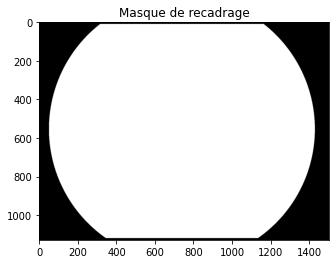

In [ ]:
mask = get_mask(img)
plt.imshow(mask, cmap = 'gray')
plt.title("Masque de recadrage")
plt.show()

In [ ]:
def apply_mask(img, mask):
  
  """
  :param img : l'image 
  :param mask : le masque à appliquer
  :return: l'image recadrée
  """
    
  h, w = img.shape[:2]
  img_mask = np.copy(img)
  for i in range(h):
    for j in range(w):
      if not mask[i][j]:
        img_mask[i][j] = 0
  return img_mask

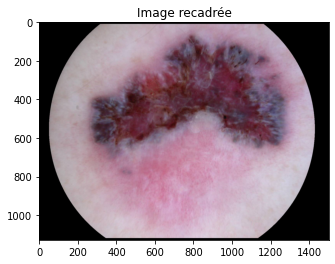

In [ ]:
plt.imshow(apply_mask(img, mask), cmap='gray')
plt.title("Image recadrée")
plt.show()

## Shadow attenuation

Les variations d'illumination de l'image peuvent compliquer la segmentation de lésions. On atténue donc ces variations sur les images concernées (une image uniformément sombre n'est pas concernée)

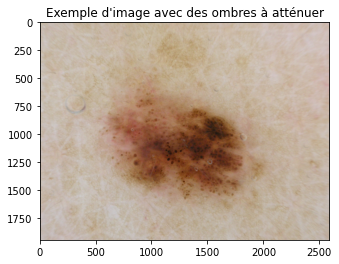

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/dataset-skinlesions/melanoma/ISIC_0000143.jpg'
img = io.imread(filepath)
plt.imshow(img)
plt.title("Exemple d'image avec des ombres à atténuer")

mask = get_mask(img)
plt.show()

On commence par déterminer si l'image a besoin d'être corrigée. 
On regarde pour cela la proportion de pixels sombres. On considère un pixel sombre si $l ≤ E(L) - σ(L)/3$ dans l'espace Lab. 

In [ ]:
def shadowDetection(img, mask):

  """
  :param img : l'image RGB
  :param mask : le masque de recadrage
  :return: Boolean True si il y a besoin d'atténuer des ombres
  """

  lab = skimage.color.rgb2lab(img)
  lab = apply_mask(lab, mask)

  nlin, ncol, _ = img.shape

  ml, c = 0, 0

  for i in range(nlin):
    for j in range(ncol):
      if mask[i,j]:
        c+=1
        ml += lab[i,j,0]
  ml = ml / c

  var = 0
  
  for i in range(nlin):
    for j in range(ncol):
      if mask[i,j]:
        var += (lab[i,j,0] - ml)**2

  var = var/c
  std = np.sqrt(var)

  c = 0 # nombre de pixels sombres

  for i in range(nlin):
    for j in range(ncol):
      if mask[i,j]:
        if lab[i,j,0] <= ml - std/3:
          c+=1
  
  if c / np.sum(mask) > 0.15 and c/np.sum(mask) < 0.25 :
    return True  
  
  return False


On sélectionne pour cela un set S de peau saine (on prend des échantillons 20x20 dans les coins de l'image, où l'on considère que l'on a de la peau saine).

In [ ]:
def setS(img, mask):

  """
  :param img : l'image RGB
  :param mask : le masque de recadrage
  :return: le set S array de luminance de peau saine et des coordonnées dans l'image du pixel
  """

  hsv = matplotlib.colors.rgb_to_hsv(img*(1/255))
  nlin, ncol, _ = np.shape(hsv)
  V = hsv[:,:,2] #Tableau contenant les V de l'image
  S = np.zeros((40,40,3))


  l,c = 0,0
  while not mask[l,c]: #haut gauche
    c += 1
    if c == ncol:
      l+=1
      c=0
  for i in range(20):
      for j in range(20):
          x = i + l
          y = j + c
          S[i,j,0], S[i,j,1] ,S[i,j,2] = V[x,y], int(x), int(y)

  l,c = 0,ncol-1
  while not mask[l,c]: #haut droit
    c += -1
    if c == -1:
      l+=1
      c=ncol - 1
  for i in range(20):
      for j in range(20):
        x = i + l
        y = c-20+j 
        S[i,20+j,0], S[i,20+j,1] ,S[i,20+j,2] = V[x,y], int(x), int(y)

  l,c = nlin-1,0
  while not mask[l,c]: #bas gauche
    c += 1
    if c == ncol:
      l += -1
      c = 0
  for i in range(20):
      for j in range(20):
          x = l-20+i
          y = j + c
          S[20+i,j,0], S[20+i,j,1] ,S[20+i,j,2] = V[x,y], int(x), int(y)

  l,c = nlin-1, ncol-1
  while not mask[l,c]: #bas droit
    c += -1
    if c == -1:
      l+= -1
      c= ncol-1          
  for i in range(20): 
      for j in range(20):
          x = l-20+i 
          y = c-20+j 
          S[20+i,20+j,0], S[20+i,20+j,1] ,S[20+i,20+j,2] = V[x,y], int(x), int(y)
          
  
  #On a notre set S de peau saine qui contient directement les V 
  return S

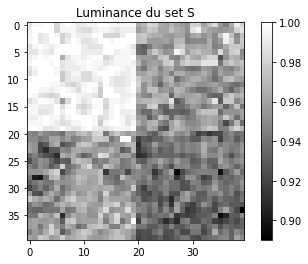

In [ ]:
plt.imshow(setS(img, mask)[:,:,0], cmap='gray')
plt.title('Luminance du set S')
plt.colorbar()
plt.show()

On cherche à approximer la luminance par une fonction quadratique $z(x,y) = P_1x^2 + P_2y^2 + P_3xy + P_4x + P_5y + P_6 $. 
Les $P_i$ sont obtenues par régression linéaire via le module de scikit-learn.


In [ ]:
def approx(S, img):

  """
  :param S : le set S de peau saine
  :param img : l'image 
  :return: un array correspondant aux valeurs de la fonction d'approximation en les points de l'image
  """

  variables = np.zeros((1600, 5))

  X = S[:,:,1].reshape(1600,)
  Y = S[:,:,2].reshape(1600,)

  variables[:, 0] = (X)**2
  variables[:, 1] = (Y)**2
  variables[:, 2] = X*Y
  variables[:, 3] = X
  variables[:, 4] = Y

  z = S[:,:,0].reshape(1600,)
  model = LinearRegression().fit(variables, z)
  (p1, p2, p3, p4, p5), p6 = model.coef_, model.intercept_


  nlin, ncol =  np.shape(img)[:2]
  coord = np.zeros(nlin*ncol*5).reshape((-1,5))
  
  for x in range(nlin):
      for y in range(ncol):
          coord[x, 0] = x**2
          coord[x, 1] = y**2
          coord[x, 2] = x*y
          coord[x, 3] = x
          coord[x, 4] = y

  Newfunc = model.predict(coord)
  zn = Newfunc.reshape((nlin,ncol))

  return zn

On remplace la valeur de la luminance par une valeur normalisée: $R(x,y) = \frac{V(x,y)}{z(x,y)}$

In [ ]:
def noShading(img, mask):

  """
  :param img : l'image RGB
  :param mask : le masque de recadrage
  :return: l'image avec les ombres atténuées si nécessaire (sans changement sinon)
  """

  if not shadowDetection(img, mask):
    return img

  S = setS(img,mask)
  zn = approx(S,img)
  nlin, ncol, _ =  np.shape(img)

  hsv = matplotlib.colors.rgb_to_hsv(img*(1/255))
  R = np.zeros((nlin,ncol))
  V = hsv[:,:,2]

  for x in range(nlin):
      for y in range (ncol):
        if zn[x, y] > 0:
          R[x,y] = V[x,y]/zn[x,y] 
        else:
          R[x,y] = V[x,y]

  hsv[:,:,2] = R[:,:]

  imgf = matplotlib.colors.hsv_to_rgb(hsv) 

  return imgf

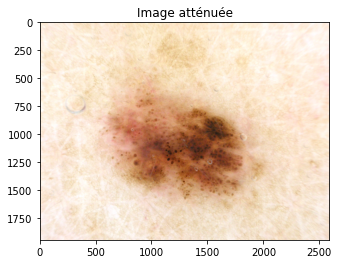

In [ ]:
plt.imshow(noShading(img, mask))
plt.title("Image atténuée")
plt.show()

## Hair Removal

Certaines images présentent des lésions en présence de poils, qui nuisent à la segmentation.

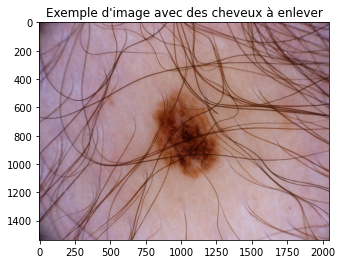

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/dataset-skinlesions/nevus/ISIC_0000095.jpg'
img = io.imread(filepath)
plt.imshow(img)
plt.title("Exemple d'image avec des cheveux à enlever")

mask = get_mask(img)
img = apply_mask(img, mask)

On identifie les pixels de poils via des fermetures morphologiques avec comme éléments structurants des rectangles (vertical et horizontal). On effectue ces opérations sur les trois canaux R, G et B de l'image.

In [ ]:
def matmax(img):

  """
  :param img : l'image RGB
  :return: tuple des masques (pour R, G et B de l'image) des pixels de poils
  """

  R = img[:,:,0]
  G = img[:,:,1]
  B = img[:,:,2]

  s0 = morphology.rectangle(50,10)
  s1 = morphology.rectangle(10,50)

  r0 = morphology.closing(R, selem=s0)
  r1 = morphology.closing(R, selem=s1)

  g0 = morphology.closing(G, selem=s0)
  g1 = morphology.closing(G, selem=s1)

  b0 = morphology.closing(B, selem=s0)
  b1 = morphology.closing(B, selem=s1)

  matmaxr = np.zeros(R.shape)
  matmaxg = np.zeros(R.shape)
  matmaxb = np.zeros(R.shape)
  nlin, ncol = R.shape

  for i in range(nlin):
    for j in range(ncol):
      matmaxr[i,j] = max(r0[i,j], r1[i,j])
      matmaxg[i,j] = max(g0[i,j], g1[i,j])
      matmaxb[i,j] = max(b0[i,j], b1[i,j])

  return (matmaxr, matmaxg, matmaxb)

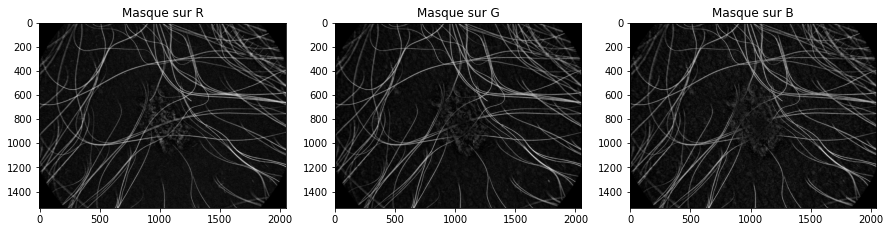

In [ ]:
(matmaxr, matmaxg, matmaxb) = matmax(img)
fig, ax = plt.subplots(1,3, figsize = (15,15))
ax[0].set_title("Masque sur R")
ax[1].set_title("Masque sur G")
ax[2].set_title("Masque sur B")
ax[0].imshow(np.abs(img[:,:,0]-matmaxr), cmap = 'gray')
ax[1].imshow(np.abs(img[:,:,1]-matmaxg), cmap = 'gray')
ax[2].imshow(np.abs(img[:,:,2]-matmaxb), cmap = 'gray')
plt.show()

On applique ensuite un seuil à ces masques et les dilatons afin de grossir les zones considérées comme des zones de poils.

In [ ]:
def hair_mask(img, matmax):

  """
  :param img : l'image RGB
  :param matmax: tuple des trois masques de poils R, G et B
  :return: tuple des masques (pour R, G et B de l'image) des pixels de poils (avec des zones de poils élargies)
  """

  R = img[:,:,0]
  G = img[:,:,1]
  B = img[:,:,2]

  matmaxr, matmaxg, matmaxb = matmax
  Mr = np.zeros(matmaxr.shape)
  Mg = np.zeros(matmaxr.shape)
  Mb = np.zeros(matmaxr.shape)

  Mr[:,:] = np.abs(R[:,:]-matmaxr[:,:]) > 40
  Mg[:,:] = np.abs(G[:,:]-matmaxg[:,:]) > 40
  Mb[:,:] = np.abs(B[:,:]-matmaxb[:,:]) > 40

  square = morphology.rectangle(20, 20)
  Mr = morphology.binary_dilation(Mr, square)
  Mb = morphology.binary_dilation(Mb, square)
  Mg = morphology.binary_dilation(Mg, square)

  return (Mr, Mg, Mb)

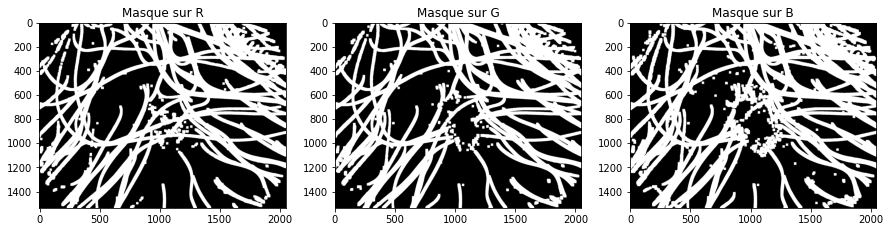

In [ ]:
Mr, Mg, Mb = hair_mask(img, (matmaxr, matmaxg, matmaxb))

fig, ax = plt.subplots(1,3, figsize = (15,15))
ax[0].set_title("Masque sur R")
ax[1].set_title("Masque sur G")
ax[2].set_title("Masque sur B")
ax[0].imshow(Mr, cmap = 'gray')
ax[1].imshow(Mg, cmap = 'gray')
ax[2].imshow(Mb, cmap = 'gray')
plt.show()

On remplace les hair-pixels par interpolation PPV

In [ ]:
#FONCTION PRISE SUR INTERNET 
def interpolate_missing_pixels(
        image: np.ndarray,
        mask: np.ndarray,
        method: str = 'nearest',
        fill_value: int = 0
):
    """
    :param image: a 2D image
    :param mask: a 2D boolean image, True indicates missing values
    :param method: interpolation method, one of
        'nearest', 'linear', 'cubic'.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
    :return: the image with missing values interpolated
    """
    
    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = interpolate.griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )

    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image

In [ ]:
def hairRemoval(img, mask):

  """
  :param img : l'image RGB
  :return: l'image sans les poils
  """
  
  matmax_ = matmax(img)
  (matmaxr, matmaxg, matmaxb) = matmax_
  (Mr, Mg, Mb) = hair_mask(img, matmax_)

  hairDetection = morphology.erosion(np.abs(img[:,:,0]-matmaxr), selem=morphology.disk(12))
  if hairDetection.sum() / mask.sum() < 0.2:
    return img

  R = img[:,:,0]
  G = img[:,:,1]
  B = img[:,:,2]

  newR = interpolate_missing_pixels(R, Mr > 0)
  newB = interpolate_missing_pixels(B, Mb > 0)
  newG = interpolate_missing_pixels(G, Mg > 0)

  square = morphology.rectangle(20, 20)
  Rf = skimage.filters.median(newR, square)
  Gf = skimage.filters.median(newG, square)
  Bf = skimage.filters.median(newB, square)

  final_img = np.copy(img)
  final_img[:,:,0]=Rf
  final_img[:,:,1]=Gf
  final_img[:,:,2]=Bf

  return final_img

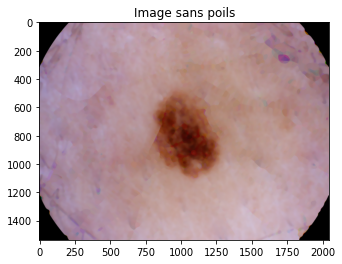

CPU times: user 1min 33s, sys: 126 ms, total: 1min 33s
Wall time: 1min 33s


In [ ]:
%%time
plt.imshow(hairRemoval(img, mask))
plt.title("Image sans poils")
plt.show()

# Seuillage

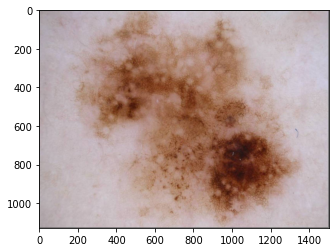

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/dataset-skinlesions/melanoma/ISIC_0000049.jpg'
img = io.imread(filepath)
plt.imshow(img)
plt.show()
mask = get_mask(img)

# Méthode SWOT

On implémente ici la méthode de l'article *A simple weighted thresholding method for the segmentation of pigmented skin lesions in macroscopic images*.\
Il s'agit d'une méthode qui se rapproche de la méthode d'Otsu appliqué à une image d'intensité, mais avec certaines spécificités.

## 1. Automatic selection of candidate skin pixels

On cherche une zone de l'image contenant que de la peau. \\
Pour ce faire, on cherche la région qui minimise le plus les variations des coefficients dans l'espace CIE-Lab. \\
On regarde pour des cercles et des bords de rectangles.

In [ ]:
def create_rectangle(nrows, ncols, thickness, h, w):

  """
  :param nrows : nombre de lignes du rectangle
  :param ncols : nombre de colonnes du rectangle
  :param thickness : épaisseur du rectangle
  :param h : hauteur de l'image
  :param w : largeur de l'image
  :return: masque d'un rectangle
  """

  x0 = h//2
  y0 = w//2
  output = np.zeros((h, w))
  rect = morphology.rectangle(nrows, ncols)
  rect2 = morphology.rectangle(nrows-thickness, ncols-thickness)
  shape_r1 = rect.shape
  output[x0-nrows//2:x0-nrows//2+shape_r1[0], y0-ncols//2:y0-ncols//2+shape_r1[1]] = rect
  shape_r2 = rect2.shape
  output[x0-(nrows-thickness)//2:x0-(nrows-thickness)//2+shape_r2[0], y0-(ncols-thickness)//2:y0-(ncols-thickness)//2+shape_r2[1]] -= rect2
  return output > 0

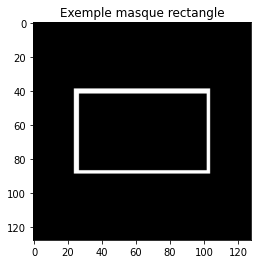

In [ ]:
plt.imshow(create_rectangle(50, 80, 5, 128, 128), cmap='gray')
plt.title('Exemple masque rectangle')
plt.show()

In [ ]:
def create_circle(radius, thickness, h, w):

  """
  :param radius : rayon du cercle
  :param thickness : épaisseur du cercle
  :param h : hauteur de l'image
  :param w : largeur de l'image
  :return: masque d'un cercle
  """

  x0 = h//2
  y0 = w//2
  output = np.zeros((h, w))
  disk = morphology.disk(radius)
  disk2 = morphology.disk(radius-thickness)
  output[x0-radius:x0+radius+1, y0-radius:y0+radius+1] = disk
  output[x0-radius+thickness:x0+radius-thickness+1, y0-radius+thickness:y0+radius-thickness+1] -= disk2
  return output > 0

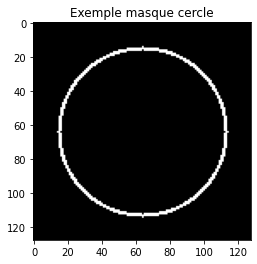

In [ ]:
plt.imshow(create_circle(50, 2, 128, 128), cmap='gray')
plt.title('Exemple masque cercle')
plt.show()

In [ ]:
def find_skin_pixels(img, mask):

  """
  :param img: l'image recadrée
  :param mask: masque de recadrage
  :return: valeur (l, a, b) moyenne de la peau, l'image de la peau en RGB, masque remplie
  """

  img_lab = skimage.color.rgb2lab(img)

  h, w, c = img_lab.shape
  
  bestL = -1
  besta = -1
  bestb = -1

  bestmask = -1
  
  step = int(0.02*max(h, w)) # c'est aussi la largeur de la région qu'on va choisir 
  
  k = 0 
  
  sumbest = np.infty
  
  skin_mask = np.zeros((h, w, c))
  
  while k*step < (1/8 * min(h, w)):
    radius = min(h, w) // 2 - k*step - 1

    circle = create_circle(radius, step, h, w)
    rect = create_rectangle(h - 2*k*step, w - 2*k*step, 2*step, h, w)

    area_c = img_lab[circle]
    area_r = img_lab[rect]

    mask_c = mask[circle] > 0
    mask_r = mask[rect] > 0
    
    # Pour calculer sur L
    Lc = area_c[:, 0]
    Lc = Lc[mask_c]
    vmlc = abs(np.var(Lc) / np.mean(Lc))

    Lr = area_r[:, 0]
    Lr = Lr[mask_r]
    vmlr = abs(np.var(Lr) / np.mean(Lr))
    
    # Pour calculer sur a
    ac = area_c[:, 1]
    ac = ac[mask_c]
    vmac = abs(np.var(ac) / np.mean(ac))
    
    ar = area_r[:, 1]
    ar = ar[mask_r]
    vmar = abs(np.var(ar) / np.mean(ar))

    # Pour calculer sur b
    bc = area_c[:, 2]
    bc = bc[mask_c]
    vmbc = abs(np.var(bc) / np.mean(bc))

    br = area_r[:, 2]
    br = br[mask_r]
    vmbr = abs(np.var(br) / np.mean(br))
    
    # On somme et on regarde si c'est la meilleure région
    if (vmlc + vmac + vmbc) < sumbest:
      sumbest = vmlc + vmac + vmbc
      skin_mask = circle
      bestL = np.mean(Lc)
      besta = np.mean(ac)
      bestb = np.mean(bc)
      bestmask = create_circle(radius, radius, h, w)

    if (vmlr + vmar + vmbr) < sumbest:
      sumbest = vmlr + vmar + vmbr
      skin_mask = rect
      bestL = np.mean(Lr)
      besta = np.mean(ar)
      bestb = np.mean(br) 
      bestmask = np.zeros((h, w))
      rect = morphology.rectangle(h - 2*k*step, w - 2*k*step)
      nrows =h - 2*k*step
      ncols = w - 2*k*step
      x0 = h//2
      y0 = w//2
      shape_r1 = rect.shape
      bestmask[x0-nrows//2:x0-nrows//2+shape_r1[0], y0-ncols//2:y0-ncols//2+shape_r1[1]] = rect
 
    k += 1
  
  skin_pixels = apply_mask(img, skin_mask)

  return (bestL, besta, bestb), skin_pixels, bestmask

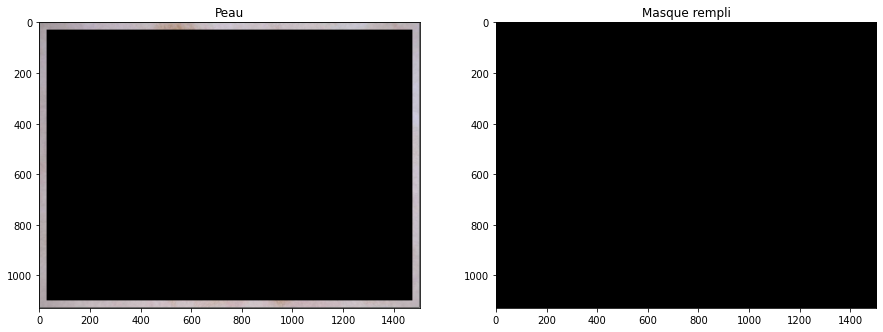

In [ ]:
(l, a, b), skin_pixels, bestmask = find_skin_pixels(img, mask)
fig, ax = plt.subplots(1,2, figsize = (15,15))
ax[0].set_title("Peau")
ax[1].set_title("Masque rempli")
ax[0].imshow(skin_pixels, cmap = 'gray')
ax[1].imshow(bestmask, cmap = 'gray')
plt.show()

## 2. Computation of an intensity image for thresholding

On crée une image d'intensité en prenant la distance euclidienne d'un pixel dans l'espace Lab dont le centre est décalé afin de correspondre à la valeur moyenne de la peau.

On effectuera ensuite le seuillage sur cette image

In [ ]:
def create_intensity_img(img, mask, lab):

  """
  :param img: l'image RGB
  :param mask: masque de recadrage
  :param lab: valeur moyenne de la peau
  :return: image d'intensité
  """

  img_lab = skimage.color.rgb2lab(img)

  (l, a, b) = lab

  h, w, c = img_lab.shape
  I = np.zeros((h, w))
  
  for i in range(h):
      for j in range(w):
        if mask[i, j]:
          I[i, j] = np.sqrt((l-img_lab[i, j, 0])**2 + (a-img_lab[i, j, 1])**2 + (b-img_lab[i, j, 2])**2)
          
  return I

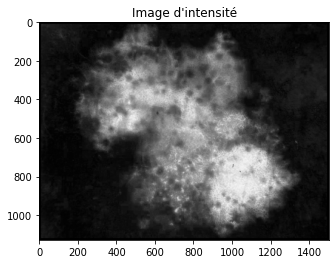

In [ ]:
I = create_intensity_img(img, mask, (l, a, b))
plt.imshow(I, cmap='gray')
plt.title("Image d'intensité")
plt.show()

## 3. Noise reduction using median filtering

In [ ]:
def median_filter(I): 

  """
  :param I: l'image d'intensité
  :return: image d'intensité filtrée
  """

  h, w = I.shape
  ws = int(0.01 * max(h,w))
  output = skimage.filters.median(I, skimage.morphology.square(ws))
  return output

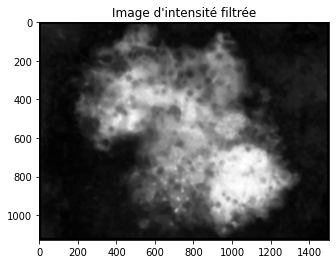

In [ ]:
I = median_filter(I)
plt.imshow(I, cmap='gray')
plt.title("Image d'intensité filtrée")
plt.show()

## 4. Threshold estimation
Le seuil de la méthode SWOT est: $$t=αt_{h}+(1-α)t_{s}$$
$t_{s}$ est un seuil obtenu avec l'image d'intensité: $$t_{s}=Γ_{0.50}+β(Γ_{0.50}-Γ_{0.05})$$
$t_{h}$ est un seuil obtenu avec deux méthodes d'Otsu. On effectue une méthode d'Otsu sur toute l'image, et une avec que les diagonales et les barres verticales et horizontales, de sorte à prendre que les parties interressantes de l'image.

Les paramètres $α$ et $β$ sont choisis arbitrairement.

In [ ]:
def hist(img, mask):

  """
  :param img : image scalaire
  :param mask : masque de recadrage
  :return: histogramme normalisé de l'image complète 
  """

  h, w = img.shape
  
  Imax = int(np.max(img))
  hist = np.zeros(Imax+1)
  cpt = 0 # Compte les pixels qu'on garde dans l'histogramme
  
  for i in range(h):
      for j in range(w):
          if mask[i][j]: # Si c'est une partie interressante de l'image
            hist[int(img[i][j])] += 1
            cpt += 1
          
  hist = hist / cpt
        
  return hist

In [ ]:
def cross_hist(img, mask, width=250):

  """
  :param img : image scalaire
  :param mask : masque de recadrage
  :param width : largeur des croix
  :return: histogramme normalisé de la partie intéressante de l'image
  """

  h, w = img.shape
  
  #le centre de l'image
  j0 = w//2
  i0 = h//2
  
  cpt = 0 #compteur pour savoir combien de pixel sont présents dans l'histogramme pour le normaliser derrière
  already_passed = np.zeros((h, w)) # vaut 1 si déjà passé par là et 0 sinon

  hist = np.zeros(int(np.max(img))+1)
  
  # De haut en bas
  for i in range(h):
      for j in range(j0-width//2, j0+width//2):
        if mask[i][j]:
          hist[int(img[i][j])] += 1
          cpt += 1
          already_passed[i][j] = 1
  
  # De gauche à droite
  for j in range(w):
      for i in range(i0-width//2, i0+width//2):
        if mask[i][j] and (not already_passed[i][j]):
          hist[int(img[i][j])] += 1
          cpt += 1
          already_passed[i][j] = 1
  
  # On fait une image carrée afin de faire des belles diagonales
  if h == w:
      img_carree = np.copy(img)
      mask_carre = mask
  elif h > w:
      diff = (h-w) // 2 
      img_carree = np.copy(img[diff:h-diff,:])
      mask_carre = np.copy(mask[diff:h-diff,:])
      already_passed_carree = np.copy(already_passed[diff:h-diff,:])
  elif h < w:
      diff = (w-h) // 2
      img_carree = np.copy(img[:,diff:w-diff])
      mask_carree = np.copy(mask[:,diff:w-diff])
      already_passed_carree = np.copy(already_passed[:,diff:w-diff])
          
  #diago haut gauche
  for k in range(-width//2, width//2):
      diag = np.diag(img_carree, k)
      already_passed_diag = np.diag(already_passed_carree, k)
      mask_diag = np.diag(mask_carree, k)
      for elt, alreadypassed, maskelt in zip(diag, already_passed_diag, mask_diag):
          if maskelt and (not alreadypassed):
              hist[int(elt)] += 1
              cpt += 1
  
  mirror_img = img_carree[:, ::-1]
  already_passed_mirror = already_passed_carree[:, ::-1]
  mirror_mask = mask_carree[:, ::-1]
  for k in range(-width//2, width//2):
      diag = np.diag(mirror_img, k)
      already_passed_diag = np.diag(already_passed_mirror, k)
      mask_diag = np.diag(mirror_mask, k)
      for elt, alreadypassed, maskelt in zip(diag, already_passed_diag, mask_diag):
          if maskelt and (not alreadypassed):
              hist[int(elt)] += 1
              cpt += 1
      
  hist = hist / cpt
        
  return hist

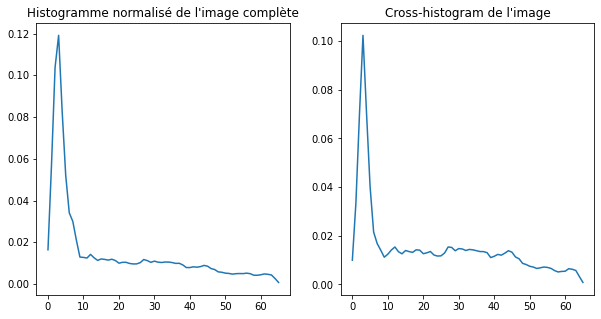

In [ ]:
hist_ = hist(I, mask)
cross_hist_ = cross_hist(I, mask)
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].set_title("Histogramme normalisé de l'image complète")
ax[1].set_title("Cross-histogram de l'image")
ax[0].plot(hist_)
ax[1].plot(cross_hist_)
plt.show()

In [ ]:
def otsu_thresh(img, mask):

  """
  :param img : image scalaire
  :param mask : masque de recadrage
  :return: th
  """  
    
  h1 = hist(img, mask) # Sur l'image complet
  h2 = cross_hist(img, mask) # Sur les diagos + croix
  
  m1 = 0
  m2 = 0

  Imax = int(np.max(img))
      
  V1 = np.zeros(Imax+1) # On stocke les variances dans un tableau
  V2 = np.zeros(Imax+1)
  
  for t in range(Imax): 
      
      # Pour sigma1
      
      w0=0
      w1=0
      m0=0
      m1=0
      for i in range(t):
          w0=w0+h1[i]
          m0=m0+i*h1[i]
      if w0 > 0:
          m0=m0/w0
      
      for i in range(t,Imax):
          w1=w1+h1[i]
          m1=m1+i*h1[i]
      if w1 > 0:   
          m1=m1/w1
              
      V1[t] = w0*w1*(m0-m1)*(m0-m1)
      
      # Pour sigma2 
      
      w0=0
      w1=0
      m0=0
      m1=0
      for i in range(t):
          w0=w0+h2[i]
          m0=m0+i*h2[i]
      if w0 > 0:
          m0=m0/w0
      
      for i in range(t,Imax):
          w1=w1+h2[i]
          m1=m1+i*h2[i]
      if w1 > 0:   
          m1=m1/w1
      
      V2[t] = w0*w1*(m0-m1)*(m0-m1)
  
  phi1 = 2*np.linalg.norm(V1)
  phi2 = 2*np.linalg.norm(V2)
  
  T = V1/phi1 + V2/phi2
  
  thresh = np.argmax(T)
      
  return thresh

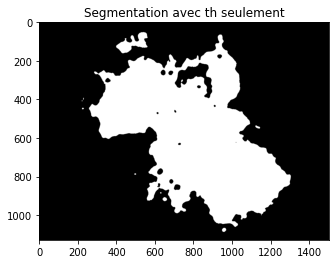

In [ ]:
th = otsu_thresh(I, mask)
plt.imshow(apply_mask(I > th, bestmask), cmap='gray')
plt.title('Segmentation avec th seulement')
plt.show()

In [ ]:
def get_ts(I, skinpixels, beta=1):

  """
  :param I : l'image d'intensité
  :param skinpixels : peau 
  :param beta : beta à ajuster (par défaut égale à 1)
  :return: ts
  """  

  skinpixels = skimage.color.rgb2gray(skinpixels)
  gamma50 = np.percentile(I[skinpixels > 0], 50)
  gamma005 = np.percentile(I[skinpixels > 0], 5)
  return gamma50 + beta * (gamma50 - gamma005)

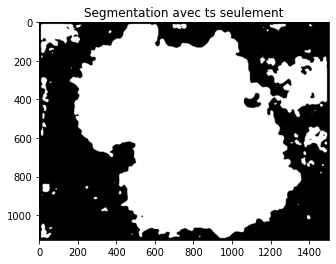

In [ ]:
ts = get_ts(I, skin_pixels)
plt.imshow(apply_mask(I > ts, bestmask), cmap='gray')
plt.title('Segmentation avec ts seulement')
plt.show()

In [ ]:
def thresh_swot(th, ts, alpha=0.8):

  """
  :param th  
  :param ts 
  :param alpha : alpha à ajuster (par défaut égale à 0.8)
  :return: seuil SWOT
  """    

  return alpha * th + (1 - alpha) * ts

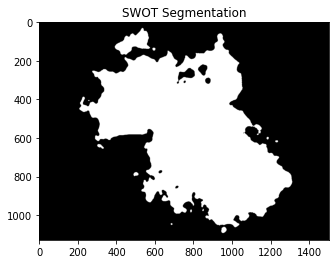

In [ ]:
t = thresh_swot(th, ts, alpha=0.8)
plt.imshow(apply_mask(I > t, mask), cmap='gray')
plt.title('SWOT Segmentation')
plt.show()

## Fonction exécutive

In [ ]:
def swot(img, mask, alpha=0.8, beta=1):

  """
  :param img: l'image RGB  
  :param alpha : alpha à ajuster (par défaut égale à 0.8)
  :param beta : beta à ajuster (par défaut égale à 1)
  :return: binary image obtenue par la méthode SWOT
  """    

  img = apply_mask(img, mask)
  (l, a, b), skinpixels, bestmask = find_skin_pixels(img, mask)
  I = create_intensity_img(img, mask, (l, a, b))
  I = median_filter(I)
  th = otsu_thresh(I, mask)
  ts = get_ts(I, skinpixels, beta)
  t = thresh_swot(th, ts, alpha)
  binary = I > t
  binary = apply_mask(binary, bestmask)
  return binary

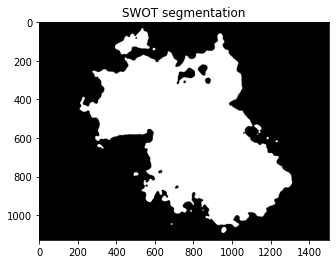

In [ ]:
binary_swot = swot(img, mask)
plt.imshow(binary_swot, cmap='gray')
plt.title('SWOT segmentation')
plt.show()

# Otsu sur image grise

Dans cette section, on effectue une segmentation par seuillage sur l'image gris d'origine avec la méthode d'Otsu classique.

On utilise certaines fonctions codées précédemment. 

In [ ]:
# INSPIRE DU CODE TROUVE EN TP
def otsu_gray_thresh(img, mask):

  """
  :param img : l'image scalaire
  :param mask : le masque de recadrage
  :return: le seuil d'otsu
  """

  img = apply_mask(img, mask)

  Imax = int(np.max(img)) + 1
    
  h = hist(img, mask) # Sur l'image complet

  varmax = -np.inf 
  thresh = 0

  for t in range(Imax): 
      
      w0=0
      w1=0
      m0=0
      m1=0
      for i in range(t):
          w0=w0+h[i]
          m0=m0+i*h[i]
      if w0 > 0:
          m0=m0/w0
      
      for i in range(t, Imax):
          w1=w1+h[i]
          m1=m1+i*h[i]
      if w1 > 0:   
          m1=m1/w1
      if w0*w1*(m0-m1)*(m0-m1) > varmax:
        thresh = t
        varmax = w0*w1*(m0-m1)*(m0-m1)

  return thresh

In [ ]:
def otsu_gray(img):

  """
  :param img : l'image RGB
  :return: binary image obtenue par la méthode d'Otsu sur l'image grise
  """

  mask = get_mask(img)
  img = apply_mask(img, mask)
  img_gray = skimage.color.rgb2gray(img) * 255
  thresh = otsu_gray_thresh(img_gray, mask)
  binary_img = img_gray < thresh
  binary = apply_mask(binary_img, mask)
  return binary

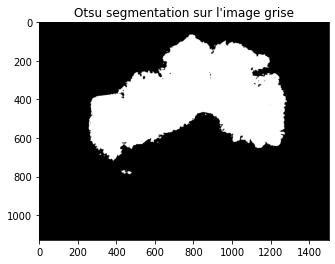

In [ ]:
binary_otsu_gray = otsu_gray(img)
plt.imshow(binary_otsu_gray, cmap='gray')
plt.title("Otsu segmentation sur l'image grise")
plt.show()

# Otsu sur canal rouge

Dans cette section, on effectue une segmentation par seuillage sur le canal rouge de l'image d'origine avec la méthode d'Otsu classique.

On utilise certaines fonctions codées précédemment.

In [ ]:
def otsu_red(img):

  """
  :param img : l'image RGB
  :return: binary image obtenue par la méthode d'Otsu sur le canal rouge de l'image
  """

  mask = get_mask(img)
  img = apply_mask(img, mask)
  red_channel = img[:,:,0]
  thresh = otsu_gray_thresh(red_channel, mask)
  binary_img = red_channel < thresh
  binary = apply_mask(binary_img, mask)
  return binary

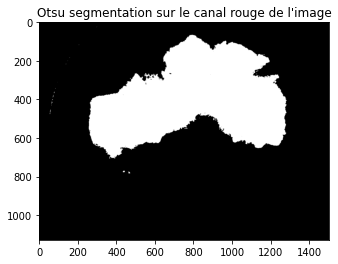

In [ ]:
binary_red = otsu_red(img)
plt.imshow(binary_red, cmap='gray')
plt.title("Otsu segmentation sur le canal rouge de l'image")
plt.show()

# Otsu sur canal vert

Dans cette section, on effectue une segmentation par seuillage sur le canal vert de l'image d'origine avec la méthode d'Otsu classique.

On utilise certaines fonctions codées précédemment.

In [ ]:
def otsu_green(img):

  """
  :param img : l'image RGB
  :return: binary image obtenue par la méthode d'Otsu sur le canal vert de l'image
  """

  mask = get_mask(img)
  img = apply_mask(img, mask)
  green_channel = img[:,:,1]
  thresh = otsu_gray_thresh(green_channel, mask)
  binary_img = green_channel < thresh
  binary = apply_mask(binary_img, mask)
  return binary

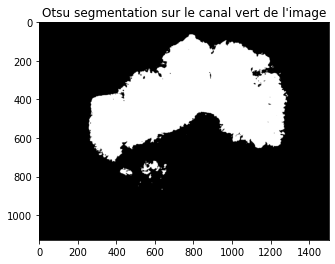

In [ ]:
binary_green = otsu_green(img)
plt.imshow(binary_green, cmap='gray')
plt.title("Otsu segmentation sur le canal vert de l'image")
plt.show()

# Otsu sur canal bleu
Dans cette section, on effectue une segmentation par seuillage sur le canal vert de l'image d'origine avec la méthode d'Otsu classique.

On utilise certaines fonctions codées précédemment.

In [ ]:
def otsu_blue(img):

  """
  :param img : l'image RGB
  :return: binary image obtenue par la méthode d'Otsu sur le canal bleu de l'image
  """

  mask = get_mask(img)
  img = apply_mask(img, mask)
  blue_channel = img[:,:,2]
  thresh = otsu_gray_thresh(blue_channel, mask)
  binary_img = blue_channel < thresh
  binary = apply_mask(binary_img, mask)
  return binary

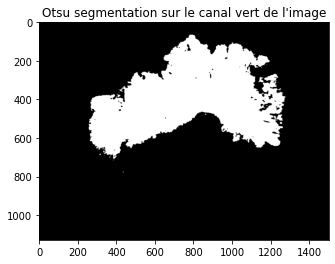

In [ ]:
binary_blue = otsu_blue(img)
plt.imshow(binary_blue, cmap='gray')
plt.title("Otsu segmentation sur le canal vert de l'image")
plt.show()

# Otsu on intensity
Dans cette section, on effectue une segmentation par seuillage sur l'image d'intensité avec la méthode d'Otsu classique.

On utilise certaines fonctions codées précédemment.

In [ ]:
def otsu_i(img):

  """
  :param img : l'image RGB
  :return: binary image obtenue par la méthode d'Otsu sur l'image d'intensité
  """

  mask = get_mask(img)
  img = apply_mask(img, mask)
  (l, a, b), skinpixels, bestmask = find_skin_pixels(img, mask)
  I = create_intensity_img(img, mask, (l, a, b))
  I = median_filter(I)
  thresh = otsu_gray_thresh(I, mask)
  binary_img = I > thresh
  binary = apply_mask(binary_img, mask)
  return binary

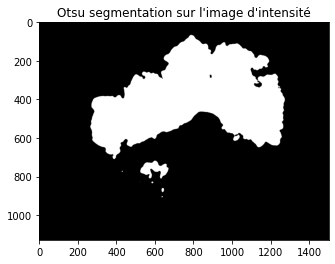

In [ ]:
binary_otsu_i = otsu_i(img)
plt.imshow(binary_otsu_i, cmap='gray')
plt.title("Otsu segmentation sur l'image d'intensité")
plt.show()

# Post processing

Nous utilisons une ouverture morphologique avec un disque afin de combler les trous et éliminer les erreurs de segmentation.

On finit par faire un remplissage convexe afin de retirer les irrégularités restantes.

In [ ]:
def postProc(binary):
  
  """
  :param binary : image binaire
  :return: image après le post-processing 
  """

  h, w = binary.shape
  m = binary
  radius = int(0.01 * max(h, w))
  disk = morphology.disk(radius)
  opened = morphology.binary_opening(m, selem=disk)
  output = morphology.convex_hull_image(opened)
  return output

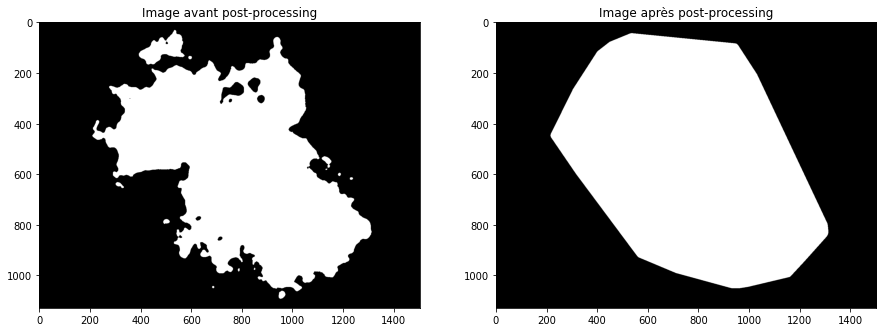

In [ ]:
final_swot = postProc(binary_swot)
fig, ax = plt.subplots(1,2, figsize = (15,15))
ax[0].set_title("Image avant post-processing")
ax[1].set_title("Image après post-processing")
ax[0].imshow(binary_swot, cmap = 'gray')
ax[1].imshow(final_swot, cmap = 'gray')
plt.show()

# Results

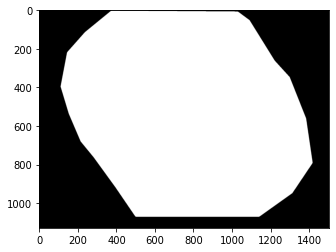

In [ ]:
filepath = '/content/drive/MyDrive/Colab Notebooks/dataset-skinlesions/melanoma/ISIC_0000049_Segmentation.png'
target = io.imread(filepath) > 0
plt.imshow(target, cmap='gray')
plt.show()

#### Pourcentage 


In [ ]:
def pourcentage(inputs, target):  #Must be binary images
    h, w = inputs.shape
    difference = 0
    for i in range(h):
        for j in range(w):
            difference += abs(int(inputs[i][j]) - int(target[i][j]))
    pourcentage = (100*difference) / (h*w)
    return pourcentage

In [ ]:
pourcentage(final_swot, target)

#### Dice Coefficient

$d = \frac{ \text{2 x Intersection}}{\text{Union + Intersection}}$ 

In [ ]:
def TP(img_binary, seg):

  """
  :param img_binary : Masque
  :param seg : Masque objectif
  :return : True Positif (intersection des deux masques)
  """

  TP_ = np.multiply(img_binary, seg)
  return TP_

In [ ]:
def FP(img_binary, seg):

  """
  :param img_binary : Masque
  :param seg : Masque objectif
  :return : False Positif (Point dans le masque qui ne devrait pas y être)
  """

  TP_ = np.multiply(img_binary, seg)
  FP_ = img_binary ^ TP_
  return FP_

In [ ]:
def FN(img_binary, seg):

  """
  :param img_binary : Masque
  :param seg : Masque objectif
  :return : False Negative (Point qui n'est pas dans le masque mais qui devrait y être)
  """

  TP_ = np.multiply(img_binary, seg)
  FN_ = seg ^ TP_
  return FN_

In [ ]:
def TN(img_binary, seg):

  """
  :param img_binary : Masque
  :param seg : Masque objectif
  :return : True Negative (Point qui n'est pas dans le masque et qui ne devrait pas y être)
  """

  TP_ = np.multiply(img_binary, seg)
  FN_ = seg ^ TP_
  FP_ = img_binary ^ TP_
  one = np.ones((seg.shape)) == 1
  TN_ = one ^ (TP_ + FN_ + FP_)
  return TN_

In [ ]:
#CODE PRIS DE INTERNET
def dice(inputs, target): 

    """
    :param inputs: Masque binaire
    :param target : Masque objectif binaire
    :return : Dice Coefficient (measure of overlap between two masks. 1 indicates a perfect overlap while 0 indicates no overlap)
    """

    num = target.shape[0]   #nombre de lignes
    inputs = inputs.reshape(num, -1)  #On forme des vecteurs colonnes (pour la multiplication terme à terme suivante)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = dice.sum() / num
    return dice


In [ ]:
#On peut aussi définir:
def dice2(i, o):
  TP_, TN_, FP_, FN_ = TP(i,o), TN(i,o), FP(i,o), FN(i,o)
  d = (2*TP_.sum())/(2*TP_.sum() + FN_.sum() + FP_.sum()) 
  return d

In [ ]:
dice(final_swot, target)

0.7688218721814181

#### Jaccard’s Index

$I = \frac{ \text{Intersection}}{\text{Union}}$

In [ ]:
#CODE INSPIRé DE INTERNET
def Jaccard(inputs, target):

    """
    :param inputs: Masque binaire
    :param target : Masque objectif binaire
    :return : Jaccard's Index
    """

    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

In [ ]:
def Jaccard2(i, o):
  TP_, FN_, FP_ = TP(i,o), FN(i,o), FP(i,o)
  J = (TP_.sum())/(TP_.sum() + FN_.sum() + FP_.sum())
  return J

In [ ]:
print(Jaccard(final_swot, target))
Jaccard2(final_swot, target)

0.802910544938549


0.6707189187439068

### Résultat sur tout le dataset

In [ ]:
from os import listdir
from os.path import isfile, join
monRepertoire1 = '/content/drive/MyDrive/Colab Notebooks/dataset-skinlesions/melanoma'
monRepertoire2 = '/content/drive/MyDrive/Colab Notebooks/dataset-skinlesions/nevus'
fichiers1 = [f for f in listdir(monRepertoire1) if isfile(join(monRepertoire1, f))]
fichiers2 = [f for f in listdir(monRepertoire2) if isfile(join(monRepertoire2, f))]

In [ ]:
#MELANOMA
targets1 = []
inputs1 = []
for file in fichiers1:
  if file[-2] == 'n':
    targets1.append('/melanoma/' + file)
  else:
    inputs1.append('/melanoma/' + file)

targets1 = np.asarray(targets1)
inputs1 = np.asarray(inputs1)

targets1 = np.sort(targets1)
inputs1 = np.sort(inputs1)

#NEVUS
targets2 = []
inputs2 = []
for file in fichiers2:
  if file[-2] == 'n':
    targets2.append('/nevus/' + file)
  else:
    inputs2.append('/nevus/' + file)

targets2 = np.asarray(targets2)
inputs2 = np.asarray(inputs2)

targets2 = np.sort(targets2)
inputs2 = np.sort(inputs2)


In [ ]:
rep = '/content/drive/MyDrive/Colab Notebooks/dataset-skinlesions'
inputs = np.concatenate((inputs1, inputs2))
targets = np.concatenate((targets1, targets2))

In [ ]:
TPs = []
TNs = []
FPs = []
FNs = []
dices = []
jacs = []
for input, target in zip(inputs, targets):
  img = io.imread(rep + input)

  mask = get_mask(img)
  prehair = hairRemoval(img, mask)
  preshad = noShading(prehair, mask)

  tp = []
  tn = []
  fp = []
  fn = []
  dicep = []
  jacp = []

#SWOT
  binary_swot = swot(preshad, mask)
  final_swot = postProc(binary_swot)

  segm = io.imread(rep + target)
  segm_binary = segm > 0

  dice_score = dice(final_swot, segm_binary)
  jac_score = Jaccard(final_swot, segm_binary)

  i = final_swot
  o = segm_binary
  TP_, TN_, FP_, FN_ = TP(i,o), TN(i,o), FP(i,o), FN(i,o)
  TP_, TN_, FP_, FN_ = TP_.sum()/mask.sum(), TN_.sum()/mask.sum(), FP_.sum()/mask.sum(), FN_.sum()/mask.sum()

  tp.append(TP_)
  tn.append(TN_)
  fp.append(FP_)
  fn.append(FN_)
  dicep.append(dice_score)
  jacp.append(jac_score)

  print(f'{input}')
  print(f'SWOT: dice =  {dice_score}, jaccard =  {jac_score}, TP = {TP_}, TN = {TN_}, FP = {FP_}, FN = {FN_}')

#OTSU GRAY
  binary_otsu = otsu_gray(preshad)
  final_otsu = postProc(binary_otsu)

  dice_score = dice(final_otsu, segm_binary)
  jac_score = Jaccard(final_otsu, segm_binary)

  i = final_otsu
  o = segm_binary
  TP_, TN_, FP_, FN_ = TP(i,o), TN(i,o), FP(i,o), FN(i,o)
  TP_, TN_, FP_, FN_ = TP_.sum()/mask.sum(), TN_.sum()/mask.sum(), FP_.sum()/mask.sum(), FN_.sum()/mask.sum()

  tp.append(TP_)
  tn.append(TN_)
  fp.append(FP_)
  fn.append(FN_)
  dicep.append(dice_score)
  jacp.append(jac_score)

  print(f'OTSU GRAY: dice =  {dice_score}, jaccard =  {jac_score}, TP = {TP_}, TN = {TN_}, FP = {FP_}, FN = {FN_}')

#OTSU RED
  binary_otsu = otsu_red(preshad)
  final_otsu = postProc(binary_otsu)

  dice_score = dice(final_otsu, segm_binary)
  jac_score = Jaccard(final_otsu, segm_binary)

  i = final_otsu
  o = segm_binary
  TP_, TN_, FP_, FN_ = TP(i,o), TN(i,o), FP(i,o), FN(i,o)
  TP_, TN_, FP_, FN_ = TP_.sum()/mask.sum(), TN_.sum()/mask.sum(), FP_.sum()/mask.sum(), FN_.sum()/mask.sum()

  tp.append(TP_)
  tn.append(TN_)
  fp.append(FP_)
  fn.append(FN_)
  dicep.append(dice_score)
  jacp.append(jac_score)

  print(f'OTSU RED: dice =  {dice_score}, jaccard =  {jac_score}, TP = {TP_}, TN = {TN_}, FP = {FP_}, FN = {FN_}')

  #OTSU BLUE
  binary_otsu = otsu_blue(preshad)
  final_otsu = postProc(binary_otsu)

  dice_score = dice(final_otsu, segm_binary)
  jac_score = Jaccard(final_otsu, segm_binary)

  i = final_otsu
  o = segm_binary
  TP_, TN_, FP_, FN_ = TP(i,o), TN(i,o), FP(i,o), FN(i,o)
  TP_, TN_, FP_, FN_ = TP_.sum()/mask.sum(), TN_.sum()/mask.sum(), FP_.sum()/mask.sum(), FN_.sum()/mask.sum()

  tp.append(TP_)
  tn.append(TN_)
  fp.append(FP_)
  fn.append(FN_)
  dicep.append(dice_score)
  jacp.append(jac_score)

  print(f'OTSU BLUE: dice =  {dice_score}, jaccard =  {jac_score}, TP = {TP_}, TN = {TN_}, FP = {FP_}, FN = {FN_}')


#OTSU GREEN
  binary_otsu = otsu_green(preshad)
  final_otsu = postProc(binary_otsu)

  dice_score = dice(final_otsu, segm_binary)
  jac_score = Jaccard(final_otsu, segm_binary)

  i = final_otsu
  o = segm_binary
  TP_, TN_, FP_, FN_ = TP(i,o), TN(i,o), FP(i,o), FN(i,o)
  TP_, TN_, FP_, FN_ = TP_.sum()/mask.sum(), TN_.sum()/mask.sum(), FP_.sum()/mask.sum(), FN_.sum()/mask.sum()

  tp.append(TP_)
  tn.append(TN_)
  fp.append(FP_)
  fn.append(FN_)
  dicep.append(dice_score)
  jacp.append(jac_score)

  print(f'OTSU GREEN: dice =  {dice_score}, jaccard =  {jac_score}, TP = {TP_}, TN = {TN_}, FP = {FP_}, FN = {FN_}')

#OTSU INTENSITE
  binary_otsu = otsu_i(preshad)
  final_otsu = postProc(binary_otsu)

  dice_score = dice(final_otsu, segm_binary)
  jac_score = Jaccard(final_otsu, segm_binary)

  i = final_otsu
  o = segm_binary
  TP_, TN_, FP_, FN_ = TP(i,o), TN(i,o), FP(i,o), FN(i,o)
  TP_, TN_, FP_, FN_ = TP_.sum()/mask.sum(), TN_.sum()/mask.sum(), FP_.sum()/mask.sum(), FN_.sum()/mask.sum()

  tp.append(TP_)
  tn.append(TN_)
  fp.append(FP_)
  fn.append(FN_)
  dicep.append(dice_score)
  jacp.append(jac_score)

  print(f'OTSU INTENSITE: dice =  {dice_score}, jaccard =  {jac_score}, TP = {TP_}, TN = {TN_}, FP = {FP_}, FN = {FN_}')

  TPs.append(tp)
  TNs.append(tn)
  FPs.append(fp)
  FNs.append(fn)
  dices.append(dicep)
  jacs.append(jacp)

/melanoma/ISIC_0000030.jpg
SWOT: dice =  0.625867608621515, jaccard =  0.8011488558990641, TP = 0.42064709319310545, TN = 0.6351571303367973, FP = 0.0010955302366345311, FN = 0.20771998545255088
OTSU GRAY: dice =  0.541329250316336, jaccard =  0.735201060142101, TP = 0.3659167873985703, TN = 0.6351168863689209, FP = 0.0011357742045109017, FN = 0.262450291247086
OTSU RED: dice =  0.5367079707533418, jaccard =  0.7292312367976024, TP = 0.36121569574367873, TN = 0.6351601113714548, FP = 0.001092549201977022, FN = 0.2671513829019776
OTSU BLUE: dice =  0.5313990281212567, jaccard =  0.7269102359214544, TP = 0.3594904219356454, TN = 0.6350185122252231, FP = 0.0012341483482086963, FN = 0.26887665671001093
OTSU GREEN: dice =  0.5930854324164334, jaccard =  0.7777867805257058, TP = 0.40062497391594676, TN = 0.6350781329183733, FP = 0.0011745276550585177, FN = 0.2277421047297096
OTSU INTENSITE: dice =  0.5804858780388314, jaccard =  0.7644348883110649, TP = 0.3892284784202901, TN = 0.63550516613

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  del sys.path[0]


OTSU BLUE: dice =  0.4687903755245307, jaccard =  0.0, TP = 0.0, TN = 0.8307668462217451, FP = 0.0, FN = 0.18748504605814093
OTSU GREEN: dice =  0.2803458801064723, jaccard =  0.31579964937057065, TP = 0.18748504605814093, TN = 0.01836990717239551, FP = 0.8123969390493496, FN = 0.0
OTSU INTENSITE: dice =  0.944760249954017, jaccard =  0.9590721021969978, TP = 0.1728938383292971, TN = 0.8306017466204091, FP = 0.00016509960133599325, FN = 0.01459120772884381
/nevus/ISIC_0000095.jpg
SWOT: dice =  0.9279074277129425, jaccard =  0.9296406299661344, TP = 0.07166445874337624, TN = 0.9805784984319239, FP = 1.1490213042067698e-05, FN = 0.01083628474099708
OTSU GRAY: dice =  0.6853353110225463, jaccard =  0.5469610458099652, TP = 0.07290472585703471, TN = 0.8694144046717854, FP = 0.11117558397318049, FN = 0.009596017627338596
OTSU RED: dice =  0.5706872813374056, jaccard =  0.4691857702513423, TP = 0.07024237590569915, TN = 0.8339106602141235, FP = 0.14667932843084244, FN = 0.012258367578674165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  del sys.path[0]


OTSU RED: dice =  0.43452764396553606, jaccard =  0.0, TP = 0.0, TN = 0.8674705166851764, FP = 0.0, FN = 0.21985899442012777
OTSU BLUE: dice =  0.5884513740240239, jaccard =  0.5914402985904725, TP = 0.20216641313037986, TN = 0.6058549426786775, FP = 0.261615574006499, FN = 0.017692581289747905
OTSU GREEN: dice =  0.5475096967135485, jaccard =  0.6238666210771615, TP = 0.16744421251145405, TN = 0.7179788163260086, FP = 0.14949170035916776, FN = 0.052414781908673706
OTSU INTENSITE: dice =  0.8150579170607742, jaccard =  0.8209940388807331, TP = 0.15309754977140255, TN = 0.8674705166851764, FP = 0.0, FN = 0.06676144464872522


On remplit ce qui manque car il manque que les valeurs pour deux images et que tester sur tout le dataset est long

On peut plot les différents résultats selon les méthodes et nous voyons bien que la méthode SWOT est la meilleure en moyenne.

En revanche, les seuils mis arbitrairement (notamment au preprocessing) rendent la chose un peu aléatoire et changeante selon l'image.

Nous pouvons tout de même être fières d'afficher de si bons résultats sans l'utilisation de deep learning.

On normalise les TN, TP, FN, FP

In [ ]:
TPn = TPs.copy()
TNn = TNs.copy()
FPn = FPs.copy()
FNn = FNs.copy()

TPn = np.asarray(TPn)
TNn = np.asarray(TNn)
FPn = np.asarray(FPn)
FNn = np.asarray(FNn)


k=0

for input, target in zip(inputs, targets):
  img = io.imread(rep + input)
  h, w, _ = img.shape

  mask = get_mask(img)

  segm = io.imread(rep + target)
  segm_binary = segm > 0

  m = np.sum(mask)
  s = np.sum(segm_binary)

  TNn[k] = (TNn[k] * m) / (h*w - s)
  TPn[k] = (TPn[k] * m) / (s)
  FNn[k] = (FNn[k] * m) / (s)
  FPn[k] = (FPn[k] * m) / (h*w - s)

  k+=1

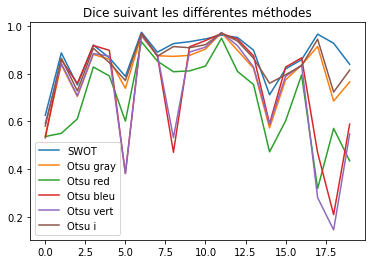

In [ ]:
plt.plot(dices)
plt.title('Dice suivant les différentes méthodes')
plt.legend(['SWOT', 'Otsu gray', 'Otsu red', 'Otsu bleu',  'Otsu vert', 'Otsu i' ])
plt.show()

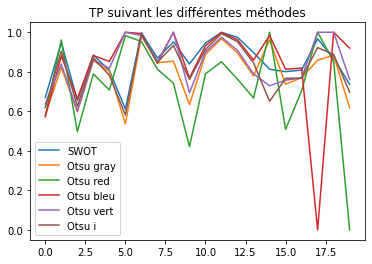

In [ ]:
plt.plot(TPn)
plt.title('TP suivant les différentes méthodes')
plt.legend(['SWOT', 'Otsu gray', 'Otsu red', 'Otsu bleu',  'Otsu vert', 'Otsu i' ])
plt.show()

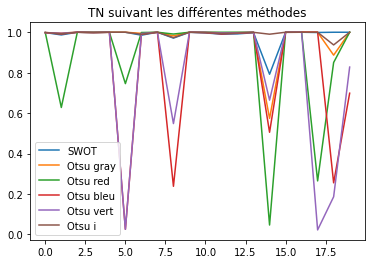

In [ ]:
plt.plot(TNn)
plt.title('TN suivant les différentes méthodes')
plt.legend(['SWOT', 'Otsu gray', 'Otsu red', 'Otsu bleu',  'Otsu vert', 'Otsu i' ])
plt.show()

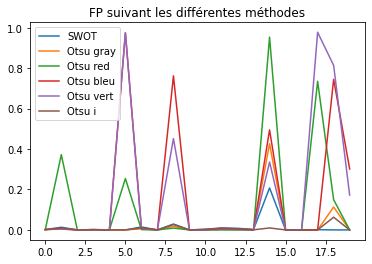

In [ ]:
plt.plot(FPn)
plt.title('FP suivant les différentes méthodes')
plt.legend(['SWOT', 'Otsu gray', 'Otsu red', 'Otsu bleu',  'Otsu vert', 'Otsu i' ])
plt.show()

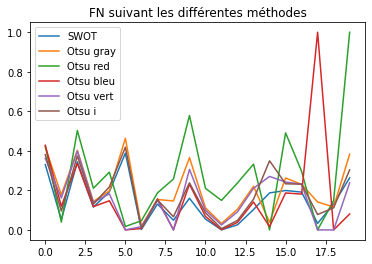

In [ ]:
plt.plot(FNn)
plt.title('FN suivant les différentes méthodes')
plt.legend(['SWOT', 'Otsu gray', 'Otsu red', 'Otsu bleu',  'Otsu vert', 'Otsu i' ])
plt.show()